## Notebook for testing MoE with MNIST  
Main objective here is to figure out how to get the gradients to go through the loss function using PyTorch

In [123]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np 
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
import random
import time
import sys
import os
import matplotlib.pyplot as plt

#for the disk_memoize function
import pickle
import hashlib
from functools import wraps
from tqdm import tqdm

# Add scripts folder path so I can get load_mnist
repo_root = os.path.abspath("..")  # one level up from /notebook
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
from scripts.MNIST import load_mnist
print(sys.path)

#just some basic stuff to set for reproducability
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

['c:\\Users\\caleb\\OneDrive - Uppsala universitet\\Fall 2025\\Projects Course\\mixture-of-experts-organization\\mixture-of-experts-project', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.2288.0_x64__qbz5n2kfra8p0\\python313.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.2288.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.2288.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.2288.0_x64__qbz5n2kfra8p0', '', 'C:\\Users\\caleb\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python313\\site-packages', 'C:\\Users\\caleb\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python313\\site-packages\\win32', 'C:\\Users\\caleb\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\\LocalCac

In [95]:
#Training test plot curve code that was provided in assignment 1 to get the plots
#modified it to contain the time and number of epochs
def training_curve_plot(title, train_costs, test_costs, train_accuracy, test_accuracy, batch_size, learning_rate, time, epochs):
    lg=18
    md=13
    sm=9
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, y=1.15, fontsize=lg)
    sub = f'| Batch size:{batch_size} | Learning rate:{learning_rate} | Number of Epochs:{epochs} | Training Time:{round(time)}sec |'
    fig.text(0.5, 0.99, sub, ha='center', fontsize=md)
    x = range(1, len(train_costs)+1)
    axs[0].plot(x, train_costs, label=f'Final train cost: {train_costs[-1]:.4f}')
    axs[0].plot(x, test_costs, label=f'Final test cost: {test_costs[-1]:.4f}')
    axs[0].set_title('Costs', fontsize=md)
    axs[0].set_xlabel('Epochs', fontsize=md)
    axs[0].set_ylabel('Cost', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    # Optionally use a logarithmic y-scale
    #axs[0].set_yscale('log')
    axs[1].plot(x, train_accuracy, label=f'Final train accuracy: {100*train_accuracy[-1]:.2f}%')
    axs[1].plot(x, test_accuracy, label=f'Final test accuracy: {100*test_accuracy[-1]:.2f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Epochs', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)


In [24]:
#want to get the data in a linear format becuase our simple MoE will be with linear layers
def get_data(linear = True):
    #get the train and test data from the dataset
    xtrain,ytrain,xtest,ytest = load_mnist.load_mnist()
    #if we want to work with flattened/ linear input
    if linear:
        xtrain = torch.Tensor(xtrain).to(DEVICE)
        ytrain = torch.Tensor(ytrain).to(DEVICE)
        xtest = torch.Tensor(xtest).to(DEVICE)
        ytest = torch.Tensor(ytest).to(DEVICE)
    else:
        #converting to Tensors for easy PyTorch implementation and reshape for a CNN
        xtrain = torch.Tensor(xtrain).reshape(60000, 1,28,28).to(DEVICE)
        ytrain = torch.Tensor(ytrain).to(DEVICE)
        xtest = torch.Tensor(xtest).reshape(10000, 1,28,28).to(DEVICE)
        ytest = torch.Tensor(ytest).to(DEVICE)
    #first we want to put our data in a pytorch dataset so we can mini batch and enumerate through it later more easily
    train_dataset = torch.utils.data.TensorDataset(xtrain, ytrain)
    test_dataset = torch.utils.data.TensorDataset(xtest, ytest)

    return train_dataset, test_dataset

#get the datasets
train_dataset, test_dataset = get_data()

Retrieving test images


100%|██████████| 10/10 [00:33<00:00,  3.34s/it]


Retrieving train images


100%|██████████| 10/10 [03:14<00:00, 19.48s/it]


In [104]:
#Making a dataloader. Batch size is 60000 for testing I was doing
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
#make the batch size for the test DataLoader the size of the dataset for evaluation.
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = test_dataset.tensors[0].shape[0], shuffle=True)

Below I really want to try and understand how backpropagation with PyTorch so I can try and implement a SoftMoE model. So we are looking in depth at just a one layer NN and then will try and figure out how this can be implemented with a gating mechanism.

In [ ]:
#calculating the accuracy given outputs not softmaxed and labels one hot encoding.
def calculate_accuracy(outputs, labels):
    #don't need to softmax because the max value will be the max softmax we just pull the index to get the digit prediction 
    _, output_index = torch.max(outputs,1)
    #get the index/ digit of the label
    _, label_index = torch.max(labels, 1)
    # return the number of correct matches and divide by the size to get accuracy
    return (output_index == label_index).sum().item()/labels.size(0)


#training loop function
def training_loop(train_loader, test_loader, num_epochs, model, loss_function, optimizer):
    #arrays for our plots
    training_loss = []
    training_accuracy = []
    test_loss = []
    test_accuracy =[]
    #Setting up the training loop
    print("Starting the Training Loop")
    for epoch in range(num_epochs):
        #keep the loss and accuracies after each mini batch
        batch_loss = []
        batch_accuracy = []
        #loop through a mini-batch on the same train loadear
        for batch_index, (data, label) in enumerate(train_loader):
            # Forward pass
            outputs = model(data)
            #evaluate the loss
            loss = loss_function(outputs, label)
            # print("Loss: ", loss)
            #append the loss to the batch loss
            batch_loss.append(loss.item())
            #calculate the accuracy based on the outputs (not softmaxed) and labels. Do outputs.data so we don't pass gradient info
            batch_accuracy.append(calculate_accuracy(outputs.data, label))
            # Backward pass setting gradients to zero
            optimizer.zero_grad()
            # print("After zero grad")
            # for name, param in model.named_parameters():
            #     print("Parameter name: ", name)
            #     print("Parameter shape: ", param.shape)
            #     print("Parameter values: ", param)
            #     print("Parameter grad: ", param.grad)
            #calcualting gradients
            loss.backward()
            # print("After backwards")
            # for name, param in model.named_parameters():
            #     print("Parameter name: ", name)
            #     print("Parameter shape: ", param.shape)
            #     print("Parameter values: ", param)
            #     print("Parameter grad: ", param.grad)

            #updating parameters
            optimizer.step()
            # print("After optimization step")
            # for name, param in model.named_parameters():
            #     print("Parameter name: ", name)
            #     print("Parameter shape: ", param.shape)
            #     print("Parameter values: ", param)
            #     print("Parameter grad: ", param.grad)

        #add to the training epoch accuracies and losses
        training_accuracy.append(np.average(batch_accuracy))
        training_loss.append(np.average(batch_loss))
        #get the test loss and accuracy
        #change mode
        model.eval()
        #so we don't accidentally change anything
        with torch.no_grad():
            #get the "batch" of the test data which is all of it
            for batch_index, (data, label) in enumerate(test_loader):
                #get our test predicitons
                test_predictions = model(data)
                #test loss and move to cpu so I can plot
                loss = loss_function(test_predictions, label).to(DEVICE)
                #append statistics
                test_loss.append(loss)
                test_accuracy.append(calculate_accuracy(test_predictions.data, label))
        #back to training mode
        model.train()
        #printing
        print(f"Epoch: {epoch} done. Test loss {test_loss[epoch]}. Test accuracy {test_accuracy[epoch]}")
    return training_loss, training_accuracy, test_loss, test_accuracy



class OneLayer(torch.nn.Module):
    def __init__(self, input_size = 784, hidden_size = 50, output_size = 10):
        super().__init__()
        #First hiddent layer
        self.hidden = torch.nn.Linear(input_size, hidden_size)
        #ReLU activation function
        self.relu = torch.nn.ReLU()
        #output layer
        self.output = torch.nn.Linear(hidden_size, output_size)
    #forward pass through the network
    def forward(self, x):
        #pass through first hidden layer

        #the shape of the input is [batch size, image size flattened]
        #print("x at start: ", x.shape)
        x = self.hidden(x)
        #activation function
        x = self.relu(x)
        #pass through the output layer
        x = self.output(x)
        return x

# setting the hyperparameters for exercise 1
input_size_1 = 784
num_classes_1 = 10
learning_rate_1 = 0.001
num_epochs_1 = 200


#This is the Neural Network model
model_one_layer= OneLayer(input_size = input_size_1, hidden_size = 50, output_size = num_classes_1).to(DEVICE)
#Our loss function will be cross entropy since we are getting a probability distribution
loss_1 = torch.nn.CrossEntropyLoss()
#Here we are going to use classic stochastic gradient descent without any special optimizations
optimizer_1 = torch.optim.SGD(model_one_layer.parameters(), lr= learning_rate_1)
start_1 = time.time()
training_loss_1, training_accuracy_1, test_loss_1, test_accuracy_1 = training_loop(train_loader, test_loader, 
num_epochs_1, model_one_layer, loss_1,optimizer_1)

end_1 = time.time()
total_time_1 = end_1 - start_1

Starting the Training Loop
Epoch: 0 done. Test loss 2.217860698699951. Test accuracy 0.3399
Epoch: 1 done. Test loss 2.124328136444092. Test accuracy 0.4921
Epoch: 2 done. Test loss 2.008212089538574. Test accuracy 0.6467
Epoch: 3 done. Test loss 1.8758795261383057. Test accuracy 0.6921
Epoch: 4 done. Test loss 1.7317849397659302. Test accuracy 0.7159
Epoch: 5 done. Test loss 1.5813500881195068. Test accuracy 0.7379
Epoch: 6 done. Test loss 1.432668924331665. Test accuracy 0.7606
Epoch: 7 done. Test loss 1.2937475442886353. Test accuracy 0.7779
Epoch: 8 done. Test loss 1.1701581478118896. Test accuracy 0.7932
Epoch: 9 done. Test loss 1.063766360282898. Test accuracy 0.8041
Epoch: 10 done. Test loss 0.9743019342422485. Test accuracy 0.815
Epoch: 11 done. Test loss 0.8994908332824707. Test accuracy 0.8241
Epoch: 12 done. Test loss 0.8371675610542297. Test accuracy 0.8306
Epoch: 13 done. Test loss 0.7847221493721008. Test accuracy 0.8364
Epoch: 14 done. Test loss 0.7404611110687256. Test 

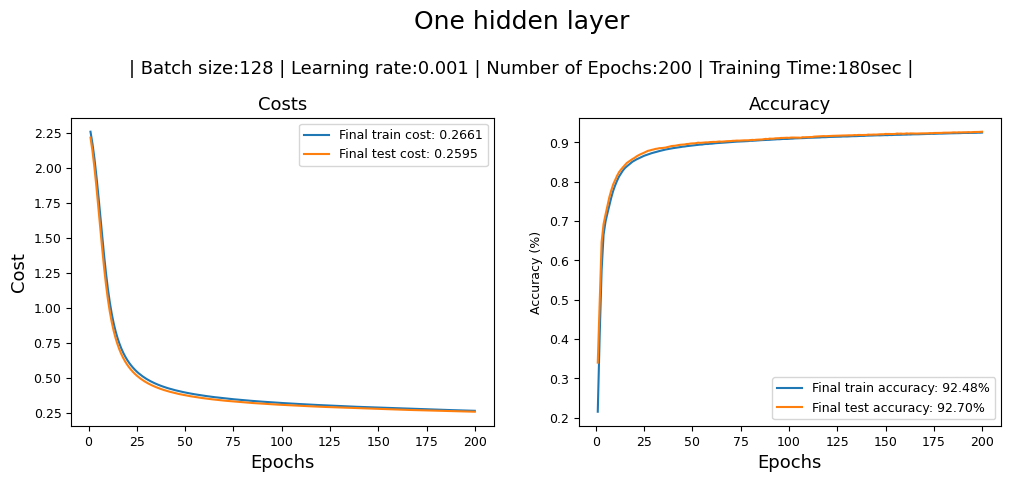

In [107]:
training_curve_plot("One hidden layer", training_loss_1, test_loss_1, training_accuracy_1, test_accuracy_1, 
                    128, learning_rate_1, total_time_1, num_epochs_1)

In [45]:
#this is how we access model parameter values and I used for testing and understanding of Pytorch
for name, param in model_one_layer.named_parameters():
    print(name, param.shape)

hidden.weight torch.Size([50, 784])
hidden.bias torch.Size([50])
output.weight torch.Size([10, 50])
output.bias torch.Size([10])


## SoftMoE implementation  
Below we have the first attempt at a SoftMoE implementation. This will pass data through all the experts and a gating mechanism which will then aggregate the output based on probabilities from the gating mechanism. This takes the form  
$\begin{equation}\sum_i^NG_i(x)E_i(x)\end{equation}$  
Where $G_i(x)$ is the output from the gating mechanism for the ith expert and $E_i(x)$ is the output from the ith expert. For our first implementation we will have one layer with only a few experts that are then aggregated to produce an output as represented in the image below (without top-k) which is cited [here](http://example.comhttps://apxml.com/posts/how-to-implement-moe-pytorch)  
![Architecture](SoftMoe.png "SoftMoE architecture")   
  
For this notebook we will just try to implement 2 experts to make sure we can train it and that both experts are used

In [99]:
#the expert layer which here is identical to the one layer network above
class Expert(torch.nn.Module):
    def __init__(self, input_size = 784, hidden_size = 50, output_size = 10):
        super().__init__()
        #First hiddent layer
        self.hidden = torch.nn.Linear(input_size, hidden_size)
        #ReLU activation function
        self.relu = torch.nn.ReLU()
        #output layer
        self.output = torch.nn.Linear(hidden_size, output_size)
    #forward pass through the network
    def forward(self, x):
        #pass through first hidden layer
        #the shape of the input is [batch size, image size flattened]
        # which is [batch size, 784]
        x = self.hidden(x)
        #activation function
        x = self.relu(x)
        #pass through the output layer
        x = self.output(x)
        return x

#the gating/ router module that will determine how much each expert should be weighted
#output size here is the number of experts
class Gating(torch.nn.Module):
    def __init__(self, input_size = 784, hidden_size = 50, output_size = 2):
        super().__init__()
        #First hiddent layer
        self.hidden = torch.nn.Linear(input_size, hidden_size)
        #ReLU activation function
        self.relu = torch.nn.ReLU()
        #output layer
        self.output = torch.nn.Linear(hidden_size, output_size)
    #forward pass through the network
    def forward(self, x):
        #pass through first hidden layer
        #the shape of the input is [batch size, image size flattened]
        # which is [batch size, 784]
        x = self.hidden(x)
        #activation function
        x = self.relu(x)
        #pass through the output layer
        x = self.output(x)
        #softmax the output
        x = F.softmax(x, dim=-1)
        return x

#implementation of a SoftMoE 
#ChatGPT says that for a SoftMoE no specialized backpropagation is needed to make this work since it is differentiable
class SoftMOE(torch.nn.Module):
    def __init__(self, input_size = 784, hidden_size_experts = 50, hidden_size_gating = 50, num_experts = 2, output_size = 10):
        super().__init__()
        self.gate = Gating(input_size=input_size, hidden_size= hidden_size_gating, output_size=num_experts)
        self.experts = nn.ModuleList(
            [Expert(input_size=input_size, hidden_size= hidden_size_experts, output_size=output_size) 
             for _ in range(num_experts)]
        )

    #forward pass through the network
    def forward(self, x):
        #this should be of size [batch size, number experts]
        weights = self.gate(x)
        # print("Weights shape: ", weights.shape)
        # print("Weights: ", weights)
        #each expert will return [batch size, output dim] and we want to take the outputs from each expert
        #and combine them according to equation 1 so we stack them 
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=2)
        # print("Experts shape: ", expert_outputs.shape)
        # print("Experts: ", expert_outputs)
        # Weighted sum across experts
        # Expand gate weights to (B × 1 × num_experts)
        # print("Weights unsqueezing shape: ", weights.unsqueeze(2).shape)
        #this operation will do batch wise matrix multiplation, so for each batch we do 
        # [10,2] * [2,1] which is the output prediction for each class for each expert times the weight associated with each expert
        # this will return a [batch size, 10, 1] tensor which we can remove the last dimension from
        output = torch.bmm(expert_outputs, weights.unsqueeze(2)).squeeze(2)
        # Result: (B × output_dim)
        return output

Here we have our first look at training the MoE with the standard training loop used above

In [101]:
lr = 0.0001
epochs = 200
moe = SoftMOE(hidden_size_experts= 25, hidden_size_gating=10)
# moe(torch.Tensor(train_dataset[0:3][0]))
#Making a dataloader for this specific CNN which is a wrapper around the Dataset for easy use
train_loader_moe = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
#make the batch size for the test DataLoader the size of the dataset for evaluation.
test_loader_moe = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = test_dataset.tensors[0].shape[0], shuffle=True)
#Our loss function will be cross entropy since we are getting a probability distribution
loss = torch.nn.CrossEntropyLoss()
#Here we are going to use classic stochastic gradient descent without any special optimizations
optimizer = torch.optim.SGD(moe.parameters(), lr= lr)
start = time.time()
training_loss_moe, training_accuracy_moe, test_loss_moe, test_accuracy_moe = training_loop(train_loader_moe, test_loader_moe, 
epochs, moe, loss, optimizer)

end = time.time()
total_time = end - start

Starting the Training Loop
Epoch: 0 done. Test loss 2.30374813079834. Test accuracy 0.1045
Epoch: 1 done. Test loss 2.3004188537597656. Test accuracy 0.118
Epoch: 2 done. Test loss 2.2971203327178955. Test accuracy 0.1323
Epoch: 3 done. Test loss 2.2938528060913086. Test accuracy 0.1484
Epoch: 4 done. Test loss 2.2906086444854736. Test accuracy 0.166
Epoch: 5 done. Test loss 2.2873711585998535. Test accuracy 0.1833
Epoch: 6 done. Test loss 2.2841336727142334. Test accuracy 0.2062
Epoch: 7 done. Test loss 2.280886173248291. Test accuracy 0.2326
Epoch: 8 done. Test loss 2.2776143550872803. Test accuracy 0.2608
Epoch: 9 done. Test loss 2.2743163108825684. Test accuracy 0.2835
Epoch: 10 done. Test loss 2.2709858417510986. Test accuracy 0.3034
Epoch: 11 done. Test loss 2.2676169872283936. Test accuracy 0.3233
Epoch: 12 done. Test loss 2.26420259475708. Test accuracy 0.3386
Epoch: 13 done. Test loss 2.260744094848633. Test accuracy 0.3531
Epoch: 14 done. Test loss 2.257232427597046. Test acc

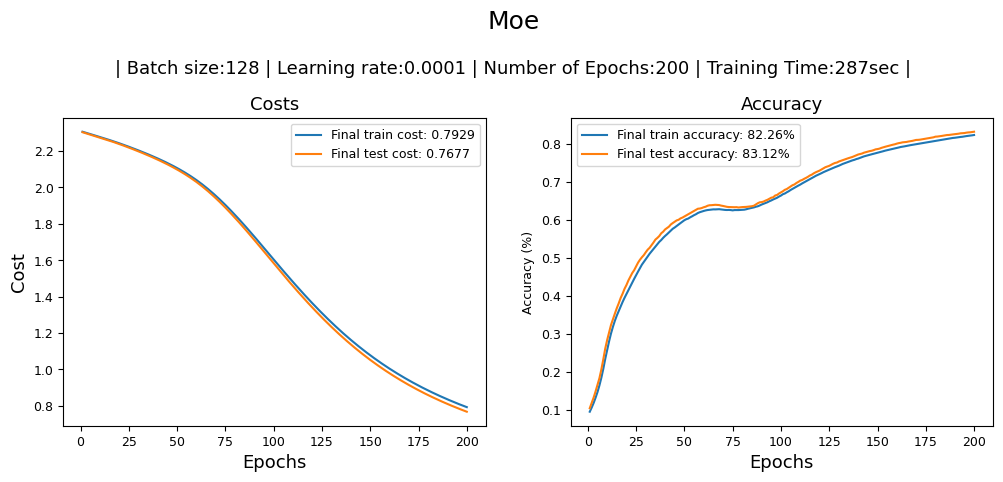

In [108]:
training_curve_plot("Moe", training_loss_moe, test_loss_moe, training_accuracy_moe, test_accuracy_moe, 
                    128, lr, total_time, epochs)

### Curve comparison  
The Moe curve is much slower than the normal linear layer and it takes a lot longer to train, but we want to see which experts are activated when; or put another way we want to see if the gating netowrk is working.

In [ ]:
#need to set the model to evaluate mode so we don't accidentally change something
moe.eval()
#this is how we access model parameter values and I used for testing and understanding of Pytorch
for name, param in moe.named_parameters():
    print(name, param.shape)
#need to look at the graph so I can extract the gating layer
print(get_graph_node_names(moe))

gate.hidden.weight torch.Size([10, 784])
gate.hidden.bias torch.Size([10])
gate.output.weight torch.Size([2, 10])
gate.output.bias torch.Size([2])
experts.0.hidden.weight torch.Size([25, 784])
experts.0.hidden.bias torch.Size([25])
experts.0.output.weight torch.Size([10, 25])
experts.0.output.bias torch.Size([10])
experts.1.hidden.weight torch.Size([25, 784])
experts.1.hidden.bias torch.Size([25])
experts.1.output.weight torch.Size([10, 25])
experts.1.output.bias torch.Size([10])
(['x', 'gate.hidden', 'gate.relu', 'gate.output', 'gate.softmax', 'experts.0.hidden', 'experts.0.relu', 'experts.0.output', 'experts.1.hidden', 'experts.1.relu', 'experts.1.output', 'stack', 'unsqueeze', 'bmm', 'squeeze'], ['x', 'gate.hidden', 'gate.relu', 'gate.output', 'gate.softmax', 'experts.0.hidden', 'experts.0.relu', 'experts.0.output', 'experts.1.hidden', 'experts.1.relu', 'experts.1.output', 'stack', 'unsqueeze', 'bmm', 'squeeze'])


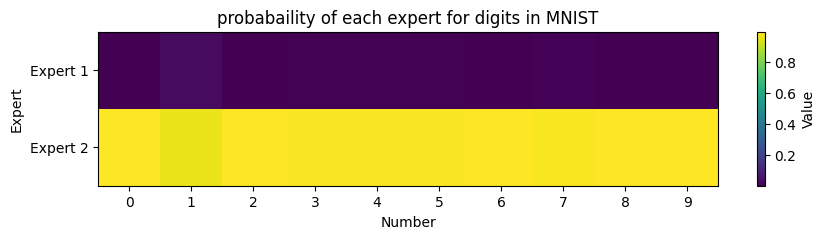

In [173]:
#this is the layer that will return the probability associated with each expert per input. this is G_i(x)
return_nodes = {
    "gate.softmax" : "probs"
}
#this is now our model that will give us the softmaxed probs for each expert per input
moe_gating = create_feature_extractor(moe, return_nodes=return_nodes)
moe_gating.eval()
loss_function = torch.nn.CrossEntropyLoss()
#we want to separate the testing dataset based on label so we can evaluate the Moe and look at the gating mechanism specific probabilities
seperated_data = [[] for _ in range(10)]
for i, (e, c) in enumerate(test_dataset):
    #get the label
    label = torch.nonzero(c == 1, as_tuple=True)[0][0].item()
    #append the index 
    seperated_data[label].append(i)

#these will be the subsets of the testdata
test_subsets = []
test_loaders = []
index = 0 
for i in seperated_data:
    #want to make a subdataset for each label
    test_subsets.append(torch.utils.data.Subset(test_dataset, i))
    #want to make a test_loader for each subset
    test_loaders.append(torch.utils.data.DataLoader(dataset=test_subsets[index], 
                                                    batch_size = len(i), shuffle=True))
    index += 1

test_loss = [[] for _ in range(10)]
test_accuracy = [[] for _ in range(10)]
expert_probs = [[] for _ in range(10)]
index = 0
for i in test_loaders:
    #change mode
    #so we don't accidentally change anything
    with torch.no_grad():
        #get the "batch" of the test data which is all of it
        for batch_index, (data, label) in enumerate(i):
            #get our test predicitons
            test_probs = moe_gating(data)
            #average along the columns of all predictions to get an idex of which expert is used
            test_probs = torch.mean(test_probs["probs"], dim = 0).tolist()
            expert_probs[index].append(test_probs)
            #print("test_probs: ", test_probs)
            #get the full model preditions
            test_predictions = moe(data)
            #test loss and move to cpu so I can plot
            loss = loss_function(test_predictions, label).to(DEVICE)
            #append statistics
            test_loss[index].append(loss)
            test_accuracy[index].append(calculate_accuracy(test_predictions.data, label))
    index += 1

expert_probs = np.array(expert_probs).squeeze().T
plt.figure(figsize=(10, 2))
plt.imshow(expert_probs, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')

plt.title("probabaility of each expert for digits in MNIST")
plt.xlabel("Number")
plt.ylabel("Expert")
plt.xticks(ticks=np.arange(10), labels=[str(i) for i in range(0, 10)])

plt.yticks([0, 1], ["Expert 1", "Expert 2"])
plt.show()